# Semesterarbeit MapReduce

## Aufgabe 1 - Throughput pro Minute

Philipp Dubach - CAS Big Data HS19/20

### Ausgangslage

Schreiben Sie ein MapReduce-Programm in Python (oder Java),<br>
welches den Throughput pro Minute bildet<br>
serverseitiges Log - nur mw_trace50 nehmen<br>
darin nur res_snd Records beachten<br>
zählen, wie res_snd pro Minute anfielen (dazu den time-Wert ohne Rest durch 1000*60 dividieren).<br>
die Werte als CSV-Datei ausgibt<br>
Stellen Sie die Entwicklung mit geeigneten Mitteln graphisch dar<br>

### Vorgehen

Ich habe mir die Aufgabe genau durchgelesen und dann den Datensatz angeschaut. <br>
Im Prinzip war mir klar, dass es genauu gleich wie das Hello World Beispiel Word_Count funktionieren muss.<br>
Die Aufgabe hat zudem noch der Hinweis wie der Schlüssel generiert werden muss, was das Ganze ein<br>
wenig einfach gestaltet.<br>
<br>
Ich wusste so auf Anhieb, dass der Schlüssel die Minute sein muss<br>
ob das so funktioniert wusste ich jedoch so noch nicht.<br>
<br>
Somit habe ich es einfach mal versucht den Schlüssel so zu setzen.<br>
Den Wert welchen ich aus dem Mapper rausgebe, war dann lediglich eine 1<br>
welche ich dann im Reducer auf die Minuten aufsummiere.<br>
<br>
Ich habe dann herausgefunden, dass ich den Mapper zum Debuggen einzeln laufen lassen kann,<br>
was mir das ganze System ein wenig klarer erscheinen liess. (Quelle: https://mrjob.readthedocs.io/en/latest/job.html)<br>
<br>
Output des Mappers war dann der Key(jede Minute) mit jedem Value welchen ich als 1 definiert hatte.<br>
Nun musste ich nur noch den Reducer dazu bringen, nach dem Key zu Gruppieren und die Aggregation auf meinen Values<br>
zu erzwingen.<br>
Dazu habe ich den Key vom Mapper wieder als Key gesetzt und den Value habe ich dann summiert.<br>
Hat alles auf Anhieb geklappt<br>
<br>
Damit das Script bei grösseren Daten effizienter auf den Cluster laufen kann,<br>
habe ich zwischen Mapper und Reducer noch einen Combiner eingesetzt.<br>
Dieser Reduziert dann jeweils seinen Block bereits auf dem jeweiligen Node und<br>
sendet dann den bereits reduzierten Datensatz an den Reducer.<br> 
<br>
Das Ganze habe ich mir dann in der Cli mittels stdout > als csv Datei abgespeichert.

### Ergebnis und Visualisation

Die Daten habe ich mir dann auf ein Git Repo gesendet damit ich es hier direkt nutzen kann,<br>
um den nachstehenden Code und dieses Dokument zu erstellen.

<b>Import Librarys</b>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from datetime import datetime
%matplotlib inline

<b>CSV in Pandas Datenframe laden</b>

In [2]:
data_tp = pd.read_csv("https://raw.githubusercontent.com/dubachphil/bigdata/master/1_1_Dubach_Philipp.csv",
                   sep='\t',
                   names=["timestamp","count"],
                  header=None)

<b>Daten prüfen<b>

In [3]:
data_tp.head()

,timestamp,count
0,1414252860,8755
1,1414252920,8707
2,1414252980,8687
3,1414253040,8458
4,1414253100,8463


In [4]:
data_tp.describe()

,timestamp,count
count,5.200000e+01,52.000000
mean,1.414252e+09,12501.788462
std,9.092854e+02,4440.705139
min,1.414251e+09,8096.000000
25%,1.414251e+09,9024.500000
50%,1.414252e+09,11029.500000
75%,1.414253e+09,14275.750000
max,1.414254e+09,25669.000000


<b> Daten aufbereiten </b>

In [5]:
data_tp["date_time"] = [datetime.fromtimestamp(int(i)) for i in data_tp["timestamp"]]
data_tp = data_tp.sort_values(by="date_time")
data_tp.head()

,timestamp,count,date_time
16,1414250520,25669,2014-10-25 17:22:00
17,1414250580,22612,2014-10-25 17:23:00
18,1414250640,23366,2014-10-25 17:24:00
19,1414250700,22102,2014-10-25 17:25:00
20,1414250760,21049,2014-10-25 17:26:00


<b>Erster Plot - Density Plot</b><br>
Der Plot zeigt wie der Anteil des Througtput pro Minute verteilt ist.<br>
Ähnlich des nächsten Histogamm Plot.<br>
Gemäss der oberen Tabelle ist das Maxima (50%) bei ca.11029 pro Minute<br>

Text(0, 0.5, 'Density')

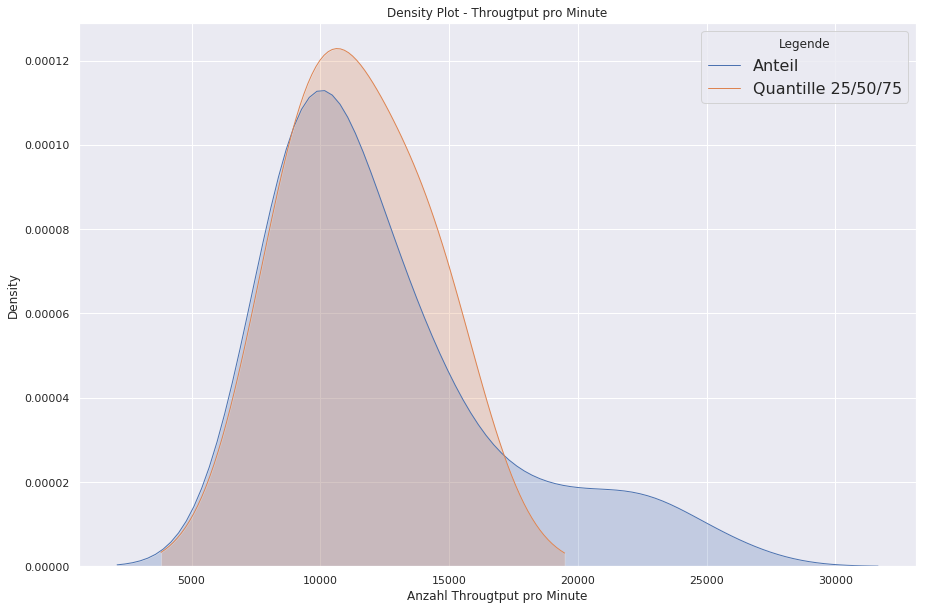

In [6]:
sns.set(rc={'figure.figsize':(15,10)})
sns.distplot(data_tp["count"], hist=False, kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = "Anteil")
sns.distplot(data_tp["count"].quantile([.25, .5, .75]), hist=False, kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = "Quantille 25/50/75")

plt.legend(prop={'size': 16}, title = 'Legende')
plt.title('Density Plot - Througtput pro Minute')
plt.xlabel('Anzahl Througtput pro Minute')
plt.ylabel('Density')

<b>Zweiter Plot - Histogramm Plot</b><br>
Der Plot zeigt im Gegensatz zum Densityplot die Häufigkeit der<br>
Througtput pro Minute

Text(0.5, 1.0, 'Histogramm - Häuigkeit der Anzahl Througtput pro Minute')

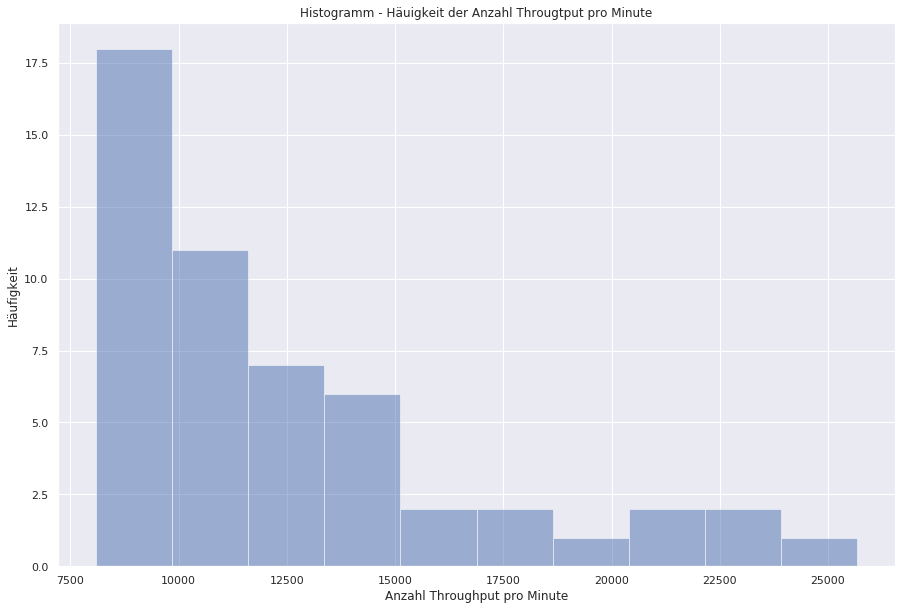

In [7]:
plt.figure(figsize=(15,10))
plt.hist(data_tp["count"],alpha=0.5,bins=10)
plt.xlabel('Anzahl Throughput pro Minute')
plt.ylabel('Häufigkeit')
plt.title('Histogramm - Häuigkeit der Anzahl Througtput pro Minute')

<b>Dritter Plot - Zeitreihe</b><br>
Anzahl Throughput pro Minute über die Zeit

Text(0, 0.5, 'Anzahl')

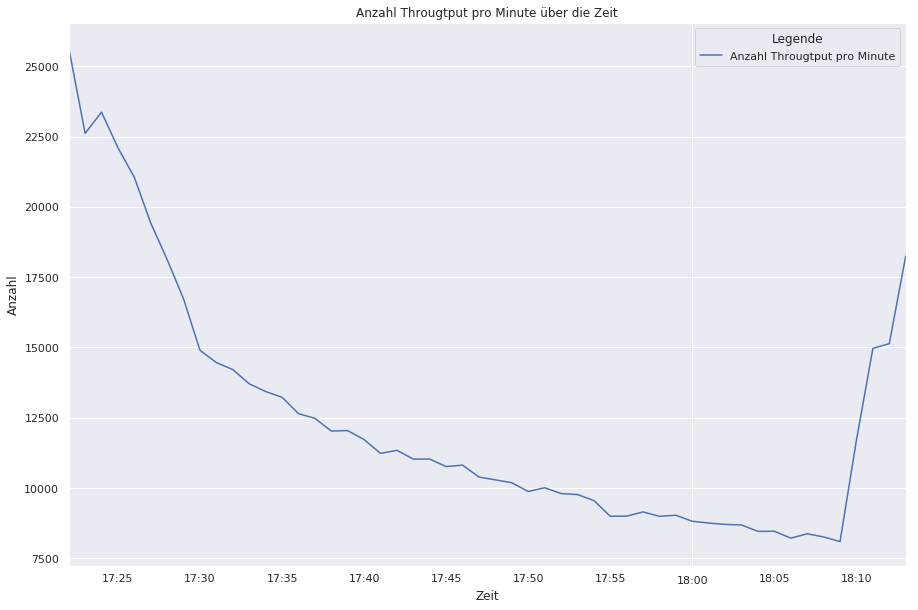

In [8]:
data_tp.plot(x="date_time",y="count",figsize=(15,10),label="Anzahl Througtput pro Minute")
plt.legend( title = 'Legende')
plt.title('Anzahl Througtput pro Minute über die Zeit')
plt.xlabel('Zeit')
plt.ylabel('Anzahl')

## Aufgabe 2 - Durchschnittliche Latenz pro Minute

### Ausgangslage

Schreiben Sie ein MapReduce-Programm in Python (oder Java),<br>
<br>
welches pro Minute den Mittelwert der Responsetime bildet <br>
clientseitiges Log client_trace50<br>
Differenz der time-Werte von Logsätzen, welche in client_id <br>
und loc_ts übereinstimmen (das sollten in der Log-Datei jeweils Paare sein)<br>
Den Mittelwert über alle Log-Sätze bilen, welche in der gleichen Minute anfielen <br>
(dazu, den time-Wert des Requests, d.h. den niedrigeren time-Wert des Logsatz-Paares, durch 1000*60 dividieren)<br>
die Werte als CSV-Datei ausgibt<br>
Stellen Sie die Entwicklung mit geeigneten Mitteln graphisch dar<br>

### Vorgehen

Die Aufgabe ist ein wenig komplexer als die erste Aufgabe.<br>
Ich habe realtiv lange gebrauch und die Systematik dahinter zu verstehen.<br>
Dies vorallem, weil es jeweils Paare sein müssen.<br>
Mir hat prinzibiel immer was gefehlt mit einem Mapper und einem Reduceer<br>
<br>
Immer wenn ich dachte ich habe es bald, hatte ich wieder haufenweise Exeptions<br>
<br>
Mir kamm dann die Idee, dass ich bei dieser Aufgabe nicht um zwei Mapper und Reducer herumkomme.<br>
<br>
Ich musste dann in der MRJOB Dokumetation https://mrjob.readthedocs.io/en/latest/ nachlesen und habe die Lösung<br>
für mein Problem gefunden<br>
<br>
Erster Mapper: 
- Ich habe einen Key aus loc_ts und client_id erstellt welcher dann jeweils zweimal aus dem Mapper kommt.<br>
- Aus Values gebe ich dann den Timestamp vom msg_send in Sekunden aus und jeweils den Timestamp von <br>
beiden Paarteilnehmer in ms

Erster Reducer:
- Den Key vom Mapper übernehme ich und gruppiere es somit
- Die Values der Timestamp Paare subrahiere ich um die Latenz zu ermitteln<br>
den Timestamp in Sekunden gebe ich auch einfach wieder mit in den nächsten Mapper

Zweiter Mapper
- Hier setze ich nun den Timestamp der msg_send in Sekunden als neuer Key
- Als Value gebe ich dann die Latenz der jeweiligen Paare mit

Zweiter Reducer
- Den Key Timestamp von msg_send überneheme ich und gruppiere somit auf die Minute des Ereignisses
- Für Latenzzeiten berechne ich nun den Durchschnitt

Eigendlich ein recht kurzes Skript, welches mich aber sehr viel Zeit gekostet hat.<br>
Somit habe ich auch demensprechend freude gehabt, als ich es dann hingekriegt habe<br>
<br>
Das CSV habe ich dann wieder auf Git hochgeladen, damit ich es hier verwenden kann.

<b>CSV in Pandas Datenframe laden</b>

In [9]:
data_lat = pd.read_csv("https://raw.githubusercontent.com/dubachphil/bigdata/master/1_2_Dubach_Philipp.csv",
                   sep='\t',
                   names=["timestamp","avg_lat"],
                  header=None)

<b>Daten prüfen</b>

In [10]:
data_lat.head()

,timestamp,avg_lat
0,1414252860,84.006794
1,1414252920,84.517108
2,1414252980,85.642924
3,1414253040,87.626930
4,1414253100,88.971571


In [11]:
data_lat.describe()

,timestamp,avg_lat
count,5.200000e+01,52.000000
mean,1.414252e+09,65.256979
std,9.092854e+02,18.296435
min,1.414251e+09,24.560475
25%,1.414251e+09,51.906364
50%,1.414252e+09,67.277955
75%,1.414253e+09,81.898660
max,1.414254e+09,90.647722


<b>Daten aufbereiten<b>

In [12]:
data_lat["date_time"] = [datetime.fromtimestamp(int(i)) for i in data_tp["timestamp"]]
data_lat = data_lat.sort_values(by="date_time")
data_lat.head()

,timestamp,avg_lat,date_time
0,1414252860,84.006794,2014-10-25 17:22:00
1,1414252920,84.517108,2014-10-25 17:23:00
2,1414252980,85.642924,2014-10-25 17:24:00
3,1414253040,87.626930,2014-10-25 17:25:00
4,1414253100,88.971571,2014-10-25 17:26:00


<b>Erster Plot - Desity Plot</b>

Text(0, 0.5, 'Density')

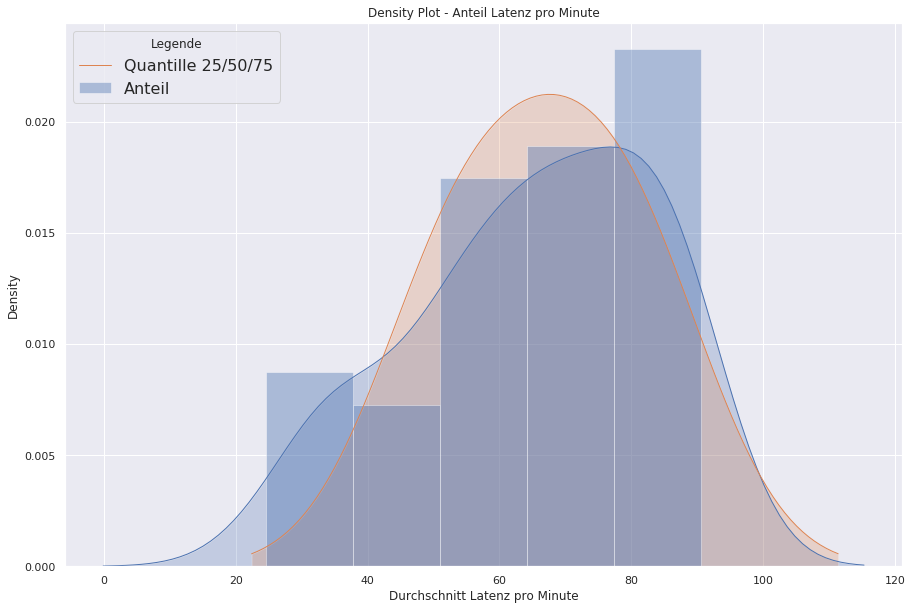

In [13]:
sns.set(rc={'figure.figsize':(15,10)})
sns.distplot(data_lat["avg_lat"], hist=True, kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = "Anteil")
sns.distplot(data_lat["avg_lat"].quantile([.25, .5, .75]), hist=False, kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = "Quantille 25/50/75")

plt.legend(prop={'size': 16}, title = 'Legende')
plt.title('Density Plot - Anteil Latenz pro Minute')
plt.xlabel('Durchschnitt Latenz pro Minute')
plt.ylabel('Density')

<b>Zweiter Plot - Histogramm Plot</b>

Text(0.5, 1.0, 'Histogramm - Häuigkeit der durchschnittlichen Latenz pro Minute')

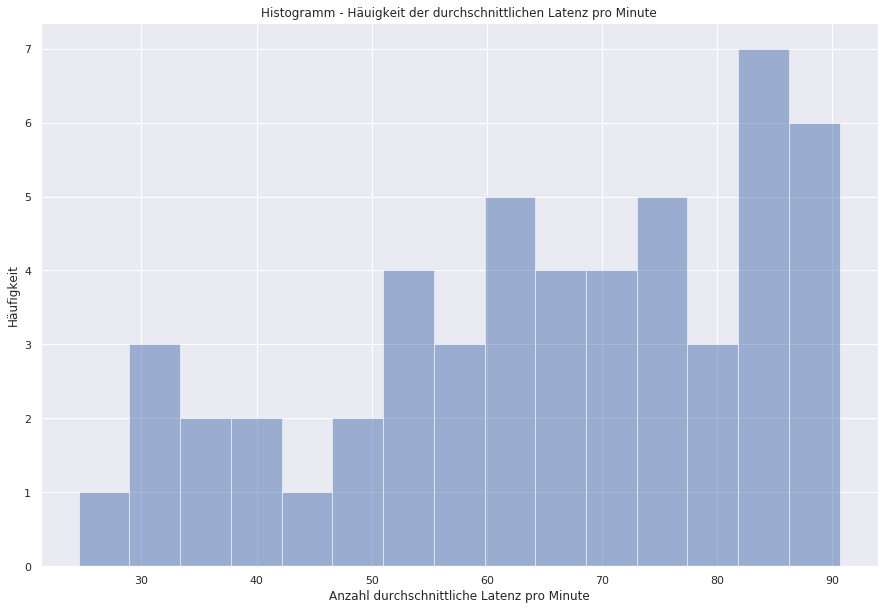

In [14]:
plt.figure(figsize=(15,10))
plt.hist(data_lat["avg_lat"],alpha=0.5,bins=15)
plt.xlabel('Anzahl durchschnittliche Latenz pro Minute')
plt.ylabel('Häufigkeit')
plt.title('Histogramm - Häuigkeit der durchschnittlichen Latenz pro Minute')

<b>Dritter Plot - Zeitreihe</b>

Text(0, 0.5, 'Latenz in ms')

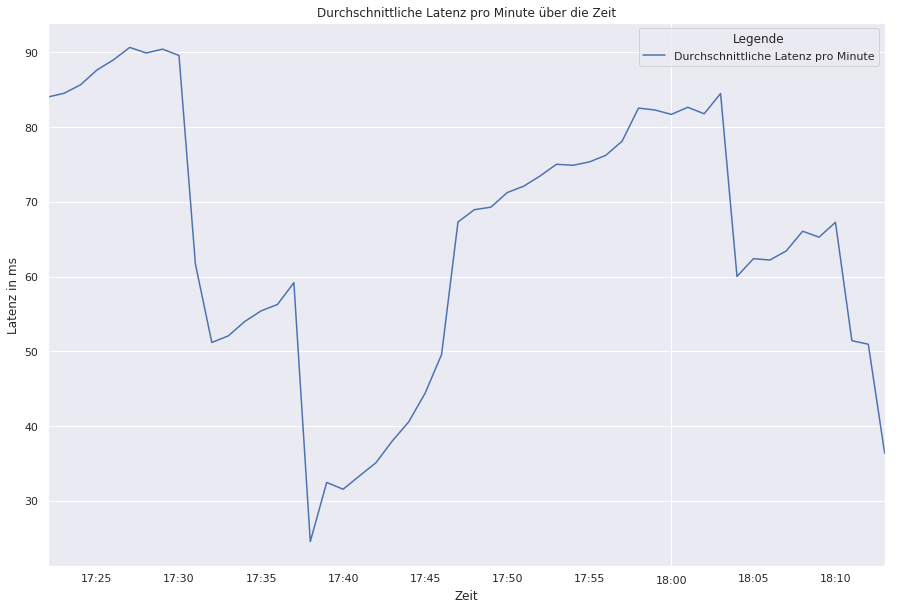

In [15]:
data_lat.plot(x="date_time",y="avg_lat",figsize=(15,10),label="Durchschnittliche Latenz pro Minute")
plt.legend( title = 'Legende')
plt.title('Durchschnittliche Latenz pro Minute über die Zeit')
plt.xlabel('Zeit')
plt.ylabel('Latenz in ms')

### Fazit Aufgabe Map Reduce

Nach der ersten Aufgabe welche ich realativ schnell erledigt hatte<br>
habe ich die zweite Aufgabe ziemlich unterschätzt.<br>
Ich habe viel Zeit investiert und eigendlich nur dank Aufgabe 2<br>
richtig erkannt und gelernt, was eingendlich genau dahinter steckt.<br>
<br>
Da ich die 2 CAS Data Analysis und Data Visualisation bereits gemacht habe<br>
wusste ich dann auch wie die Daten dann genutzt und Visualisiert werden können.<br>
<br>
Ich sehe in Map/Reduce sogar ein Projekt, welches ich in der Arbeit einsetzen kann<br>
Auf habe ich freude, weil ich mir einbilde, das ich diese Aufgabe korrekt gelöst habe.<br>
Ob der Weg nun korrekt ist, werde ich von Ihnen ja noch erfahren<br>
<br>
Vielen lieben Dank<br>
Philipp Dubach